In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
from itertools import product

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [2]:
class Net(nn.Module):
    def __init__(self,norm_type='LN',dropout_value = 0.03):
        super(Net, self).__init__()
        self.conv1 = self.conv2d(1, 8, 3,norm_type,dropout_value,2)
        self.conv2 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        
        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        
        self.conv3 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        self.conv4 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.conv5 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)
        self.conv6 =  self.conv2d(16, 16, 1,norm_type,dropout_value,4) 
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 

    def conv2d(self, in_channels, out_channels, kernel_size, norm_type, dropout,num_of_groups):
        if norm_type == "BN":
         conv = nn.Sequential(OrderedDict([
                ('conv2d', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('BatchNorm',nn.BatchNorm2d(out_channels)),
                ('Dropout', nn.Dropout(dropout))
         ]))
        elif norm_type == "LN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ## When number of groups is 1, its layernorm
                ('LayerNorm',nn.GroupNorm(1,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        elif norm_type == "GN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('GroupNorm',nn.GroupNorm(num_of_groups,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        else:
            conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
      
        return conv

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool2d(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('LN',0.03).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
#dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [7]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

    


In [8]:

def test(model, device, test_loader,test_acc,test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))




In [9]:
def experiments(train_loader, test_loader, norm_type, l1_factor, l2_factor, dropout, epochs, batchSize):
    
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
  
    model = Net(norm_type, dropout).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7,weight_decay=l2_factor)
    scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=epochs,steps_per_epoch=len(train_loader))
    epochs = epochs

    for epoch in range(1, epochs + 1):
      print(f'Epoch {epoch}:')
      train(model, device, train_loader, optimizer, epoch, train_accuracy, train_losses, l1_factor,scheduler)
      test(model, device, test_loader,test_accuracy,test_losses)

    return (train_accuracy,train_losses,test_accuracy,test_losses),model

In [10]:
'''exp = {  
    'BatchNorm':[]
    'BatchNorm+L1':['BN',0.002,0]
}'''
parameters = dict(
    batch_size = [64,128]
    ,l1 = [0, .001, .002]
    ,l2 = [0, .001, .002]
)

param_values = [v for v in parameters.values()]

for batch_size, l1, l2 in product(*param_values): 
  exp_metrics = {}
  dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
  train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
  test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)
  print('\n' +'\033[1m' + '=====================================Model Training for batch size:  ' + str(batch_size) + ',l1:  '+ str(l1) + ',l2: '+str(l2) +'======================================================'+'\033[0m\n')
  (exp_metrics['LN']),model = experiments(train_loader, test_loader,'LN',l1,l2,0.03,20,batch_size)
 ## torch.save(model, './{}.pt'.format('BN_'+str(batch_size) + 'l1_'+ str(l1) + ',l2_'+str(l2)))

'''for e in exp.items():
  print('\n' +'\033[1m' + '=====================================Model Training for '+ f'{e[0]} ======================================================'+'\033[0m\n')
  (exp_metrics[e[0]]),model = experiments(train_loader, test_loader,'BN',e[1][1],e[1][2],0.03,20)
  torch.save(model, './{}.pt'.format(e[0]))'''

  0%|          | 0/938 [00:00<?, ?it/s]


=====================================Model Training for batch size:  64,l1:  0,l2: 0======================================================

Epoch 1:


Loss=0.17837873101234436 Batch_id=937 Accuracy=76.13: 100%|██████████| 938/938 [00:30<00:00, 31.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1124, Accuracy: 9757/10000 (97.57%)

Epoch 2:


Loss=0.03984694555401802 Batch_id=937 Accuracy=94.67: 100%|██████████| 938/938 [00:30<00:00, 30.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0609, Accuracy: 9825/10000 (98.25%)

Epoch 3:


Loss=0.11798017472028732 Batch_id=937 Accuracy=96.13: 100%|██████████| 938/938 [00:30<00:00, 30.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9859/10000 (98.59%)

Epoch 4:


Loss=0.008045240305364132 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [00:30<00:00, 30.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9895/10000 (98.95%)

Epoch 5:


Loss=0.07063215970993042 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [00:30<00:00, 30.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9905/10000 (99.05%)

Epoch 6:


Loss=0.039585601538419724 Batch_id=937 Accuracy=97.55: 100%|██████████| 938/938 [00:30<00:00, 30.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9898/10000 (98.98%)

Epoch 7:


Loss=0.027657771483063698 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [00:31<00:00, 30.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9903/10000 (99.03%)

Epoch 8:


Loss=0.008550661616027355 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:31<00:00, 30.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9912/10000 (99.12%)

Epoch 9:


Loss=0.0015880994033068419 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [00:30<00:00, 30.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9920/10000 (99.20%)

Epoch 10:


Loss=0.011299512349069118 Batch_id=937 Accuracy=98.16: 100%|██████████| 938/938 [00:31<00:00, 30.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9908/10000 (99.08%)

Epoch 11:


Loss=0.29773008823394775 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [00:31<00:00, 30.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

Epoch 12:


Loss=0.02727448008954525 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:30<00:00, 30.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

Epoch 13:


Loss=0.03607756271958351 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:31<00:00, 30.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9921/10000 (99.21%)

Epoch 14:


Loss=0.005327288061380386 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:30<00:00, 30.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9927/10000 (99.27%)

Epoch 15:


Loss=0.0031572235748171806 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:31<00:00, 30.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9920/10000 (99.20%)

Epoch 16:


Loss=0.031324319541454315 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:30<00:00, 30.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

Epoch 17:


Loss=0.00456409202888608 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:30<00:00, 30.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

Epoch 18:


Loss=0.07763800024986267 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:31<00:00, 30.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9944/10000 (99.44%)

Epoch 19:


Loss=0.0115334028378129 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:31<00:00, 30.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

Epoch 20:


Loss=0.004569080658257008 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:31<00:00, 30.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.48%)


=====================================Model Training for batch size:  64,l1:  0,l2: 0.001======================================================

Epoch 1:


Loss=0.1744801551103592 Batch_id=937 Accuracy=71.19: 100%|██████████| 938/938 [00:30<00:00, 30.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1381, Accuracy: 9706/10000 (97.06%)

Epoch 2:


Loss=0.30377766489982605 Batch_id=937 Accuracy=94.23: 100%|██████████| 938/938 [00:31<00:00, 30.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9861/10000 (98.61%)

Epoch 3:


Loss=0.08950375020503998 Batch_id=937 Accuracy=96.29: 100%|██████████| 938/938 [00:30<00:00, 30.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9839/10000 (98.39%)

Epoch 4:


Loss=0.05920980125665665 Batch_id=937 Accuracy=96.85: 100%|██████████| 938/938 [00:30<00:00, 30.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9896/10000 (98.96%)

Epoch 5:


Loss=0.05954195186495781 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [00:30<00:00, 30.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9904/10000 (99.04%)

Epoch 6:


Loss=0.13829271495342255 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [00:30<00:00, 30.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9915/10000 (99.15%)

Epoch 7:


Loss=0.0597868449985981 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:30<00:00, 30.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)

Epoch 8:


Loss=0.020970840007066727 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [00:30<00:00, 30.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

Epoch 9:


Loss=0.03284665197134018 Batch_id=937 Accuracy=97.70: 100%|██████████| 938/938 [00:30<00:00, 30.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9919/10000 (99.19%)

Epoch 10:


Loss=0.04400426894426346 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [00:30<00:00, 30.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9885/10000 (98.85%)

Epoch 11:


Loss=0.040576111525297165 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:30<00:00, 30.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9899/10000 (98.99%)

Epoch 12:


Loss=0.11762328445911407 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [00:30<00:00, 30.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9931/10000 (99.31%)

Epoch 13:


Loss=0.07420141994953156 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:30<00:00, 30.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9923/10000 (99.23%)

Epoch 14:


Loss=0.010020202957093716 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:30<00:00, 30.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9924/10000 (99.24%)

Epoch 15:


Loss=0.007609063759446144 Batch_id=937 Accuracy=98.31: 100%|██████████| 938/938 [00:30<00:00, 30.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

Epoch 16:


Loss=0.09894299507141113 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:30<00:00, 30.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9930/10000 (99.30%)

Epoch 17:


Loss=0.03985343873500824 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [00:30<00:00, 30.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9944/10000 (99.44%)

Epoch 18:


Loss=0.005365002900362015 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:30<00:00, 30.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9949/10000 (99.49%)

Epoch 19:


Loss=0.00848728884011507 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:30<00:00, 30.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0162, Accuracy: 9957/10000 (99.57%)

Epoch 20:


Loss=0.007796924095600843 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:31<00:00, 30.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9956/10000 (99.56%)


=====================================Model Training for batch size:  64,l1:  0,l2: 0.002======================================================

Epoch 1:


Loss=0.19412751495838165 Batch_id=937 Accuracy=75.33: 100%|██████████| 938/938 [00:31<00:00, 29.48it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1601, Accuracy: 9620/10000 (96.20%)

Epoch 2:


Loss=0.13539575040340424 Batch_id=937 Accuracy=94.27: 100%|██████████| 938/938 [00:31<00:00, 29.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0743, Accuracy: 9813/10000 (98.13%)

Epoch 3:


Loss=0.03484504669904709 Batch_id=937 Accuracy=96.11: 100%|██████████| 938/938 [00:31<00:00, 30.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9849/10000 (98.49%)

Epoch 4:


Loss=0.10671466588973999 Batch_id=937 Accuracy=96.76: 100%|██████████| 938/938 [00:31<00:00, 30.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9878/10000 (98.78%)

Epoch 5:


Loss=0.026931198313832283 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [00:31<00:00, 30.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9864/10000 (98.64%)

Epoch 6:


Loss=0.10118009895086288 Batch_id=937 Accuracy=97.10: 100%|██████████| 938/938 [00:31<00:00, 29.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9859/10000 (98.59%)

Epoch 7:


Loss=0.24269792437553406 Batch_id=937 Accuracy=97.14: 100%|██████████| 938/938 [00:31<00:00, 29.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9900/10000 (99.00%)

Epoch 8:


Loss=0.14465610682964325 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [00:31<00:00, 30.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9852/10000 (98.52%)

Epoch 9:


Loss=0.20835237205028534 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:31<00:00, 29.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9848/10000 (98.48%)

Epoch 10:


Loss=0.2120979130268097 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [00:31<00:00, 30.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9912/10000 (99.12%)

Epoch 11:


Loss=0.06661010533571243 Batch_id=937 Accuracy=97.41: 100%|██████████| 938/938 [00:31<00:00, 30.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9915/10000 (99.15%)

Epoch 12:


Loss=0.15454690158367157 Batch_id=937 Accuracy=97.54: 100%|██████████| 938/938 [00:30<00:00, 30.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9902/10000 (99.02%)

Epoch 13:


Loss=0.061375245451927185 Batch_id=937 Accuracy=97.62: 100%|██████████| 938/938 [00:31<00:00, 30.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9915/10000 (99.15%)

Epoch 14:


Loss=0.0841120108962059 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:31<00:00, 29.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9911/10000 (99.11%)

Epoch 15:


Loss=0.04748235642910004 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:31<00:00, 30.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9919/10000 (99.19%)

Epoch 16:


Loss=0.07957730442285538 Batch_id=937 Accuracy=98.10: 100%|██████████| 938/938 [00:31<00:00, 29.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9904/10000 (99.04%)

Epoch 17:


Loss=0.19460034370422363 Batch_id=937 Accuracy=98.40: 100%|██████████| 938/938 [00:31<00:00, 30.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9927/10000 (99.27%)

Epoch 18:


Loss=0.2755633294582367 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:31<00:00, 29.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9940/10000 (99.40%)

Epoch 19:


Loss=0.01056802086532116 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [00:31<00:00, 29.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9942/10000 (99.42%)

Epoch 20:


Loss=0.008587108924984932 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:31<00:00, 29.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9942/10000 (99.42%)


=====================================Model Training for batch size:  64,l1:  0.001,l2: 0======================================================

Epoch 1:


Loss=0.7000555992126465 Batch_id=937 Accuracy=77.03: 100%|██████████| 938/938 [00:32<00:00, 29.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1187, Accuracy: 9742/10000 (97.42%)

Epoch 2:


Loss=0.5645236968994141 Batch_id=937 Accuracy=94.56: 100%|██████████| 938/938 [00:32<00:00, 29.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9762/10000 (97.62%)

Epoch 3:


Loss=0.5167317986488342 Batch_id=937 Accuracy=95.10: 100%|██████████| 938/938 [00:32<00:00, 29.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0898, Accuracy: 9731/10000 (97.31%)

Epoch 4:


Loss=0.49054330587387085 Batch_id=937 Accuracy=95.24: 100%|██████████| 938/938 [00:32<00:00, 29.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0768, Accuracy: 9786/10000 (97.86%)

Epoch 5:


Loss=0.6351132988929749 Batch_id=937 Accuracy=95.32: 100%|██████████| 938/938 [00:32<00:00, 28.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9805/10000 (98.05%)

Epoch 6:


Loss=0.6046193838119507 Batch_id=937 Accuracy=95.31: 100%|██████████| 938/938 [00:32<00:00, 28.99it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0866, Accuracy: 9759/10000 (97.59%)

Epoch 7:


Loss=0.38931891322135925 Batch_id=937 Accuracy=95.53: 100%|██████████| 938/938 [00:32<00:00, 29.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9797/10000 (97.97%)

Epoch 8:


Loss=0.3902987539768219 Batch_id=937 Accuracy=95.57: 100%|██████████| 938/938 [00:32<00:00, 28.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0977, Accuracy: 9691/10000 (96.91%)

Epoch 9:


Loss=0.36154791712760925 Batch_id=937 Accuracy=95.77: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9785/10000 (97.85%)

Epoch 10:


Loss=0.7109794616699219 Batch_id=937 Accuracy=95.86: 100%|██████████| 938/938 [00:32<00:00, 29.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0736, Accuracy: 9781/10000 (97.81%)

Epoch 11:


Loss=0.35616153478622437 Batch_id=937 Accuracy=95.88: 100%|██████████| 938/938 [00:32<00:00, 29.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9842/10000 (98.42%)

Epoch 12:


Loss=0.40655016899108887 Batch_id=937 Accuracy=95.82: 100%|██████████| 938/938 [00:32<00:00, 29.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9838/10000 (98.38%)

Epoch 13:


Loss=0.49058154225349426 Batch_id=937 Accuracy=96.08: 100%|██████████| 938/938 [00:32<00:00, 29.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9873/10000 (98.73%)

Epoch 14:


Loss=0.2992168962955475 Batch_id=937 Accuracy=96.16: 100%|██████████| 938/938 [00:32<00:00, 29.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9866/10000 (98.66%)

Epoch 15:


Loss=0.43492352962493896 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:32<00:00, 29.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9846/10000 (98.46%)

Epoch 16:


Loss=0.29447633028030396 Batch_id=937 Accuracy=96.80: 100%|██████████| 938/938 [00:32<00:00, 29.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9869/10000 (98.69%)

Epoch 17:


Loss=0.2580592632293701 Batch_id=937 Accuracy=97.08: 100%|██████████| 938/938 [00:32<00:00, 28.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9871/10000 (98.71%)

Epoch 18:


Loss=0.41793668270111084 Batch_id=937 Accuracy=97.64: 100%|██████████| 938/938 [00:32<00:00, 28.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9904/10000 (99.04%)

Epoch 19:


Loss=0.22671914100646973 Batch_id=937 Accuracy=97.99: 100%|██████████| 938/938 [00:32<00:00, 29.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9932/10000 (99.32%)

Epoch 20:


Loss=0.38561955094337463 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9936/10000 (99.36%)


=====================================Model Training for batch size:  64,l1:  0.001,l2: 0.001======================================================

Epoch 1:


Loss=0.5572324395179749 Batch_id=937 Accuracy=77.89: 100%|██████████| 938/938 [00:32<00:00, 29.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1138, Accuracy: 9773/10000 (97.73%)

Epoch 2:


Loss=0.4360909163951874 Batch_id=937 Accuracy=94.13: 100%|██████████| 938/938 [00:32<00:00, 28.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0757, Accuracy: 9810/10000 (98.10%)

Epoch 3:


Loss=0.7240184545516968 Batch_id=937 Accuracy=95.10: 100%|██████████| 938/938 [00:32<00:00, 28.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0765, Accuracy: 9788/10000 (97.88%)

Epoch 4:


Loss=0.43881165981292725 Batch_id=937 Accuracy=95.17: 100%|██████████| 938/938 [00:32<00:00, 28.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1127, Accuracy: 9690/10000 (96.90%)

Epoch 5:


Loss=0.4228379726409912 Batch_id=937 Accuracy=94.97: 100%|██████████| 938/938 [00:32<00:00, 28.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0854, Accuracy: 9792/10000 (97.92%)

Epoch 6:


Loss=0.6511314511299133 Batch_id=937 Accuracy=95.17: 100%|██████████| 938/938 [00:32<00:00, 28.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9853/10000 (98.53%)

Epoch 7:


Loss=0.4875359535217285 Batch_id=937 Accuracy=95.17: 100%|██████████| 938/938 [00:32<00:00, 28.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Accuracy: 9797/10000 (97.97%)

Epoch 8:


Loss=0.47516322135925293 Batch_id=937 Accuracy=95.08: 100%|██████████| 938/938 [00:32<00:00, 28.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1241, Accuracy: 9668/10000 (96.68%)

Epoch 9:


Loss=0.4030877947807312 Batch_id=937 Accuracy=95.23: 100%|██████████| 938/938 [00:32<00:00, 28.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0701, Accuracy: 9804/10000 (98.04%)

Epoch 10:


Loss=0.40785396099090576 Batch_id=937 Accuracy=95.25: 100%|██████████| 938/938 [00:32<00:00, 28.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9826/10000 (98.26%)

Epoch 11:


Loss=0.36058613657951355 Batch_id=937 Accuracy=95.37: 100%|██████████| 938/938 [00:32<00:00, 28.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0714, Accuracy: 9794/10000 (97.94%)

Epoch 12:


Loss=0.3172053396701813 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:32<00:00, 28.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9798/10000 (97.98%)

Epoch 13:


Loss=0.845909833908081 Batch_id=937 Accuracy=95.67: 100%|██████████| 938/938 [00:32<00:00, 28.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9847/10000 (98.47%)

Epoch 14:


Loss=0.36546623706817627 Batch_id=937 Accuracy=95.81: 100%|██████████| 938/938 [00:32<00:00, 28.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0708, Accuracy: 9803/10000 (98.03%)

Epoch 15:


Loss=0.5690497756004333 Batch_id=937 Accuracy=95.95: 100%|██████████| 938/938 [00:32<00:00, 28.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9880/10000 (98.80%)

Epoch 16:


Loss=0.39817529916763306 Batch_id=937 Accuracy=96.57: 100%|██████████| 938/938 [00:32<00:00, 28.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0539, Accuracy: 9862/10000 (98.62%)

Epoch 17:


Loss=0.4940142035484314 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [00:32<00:00, 29.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9801/10000 (98.01%)

Epoch 18:


Loss=0.24546602368354797 Batch_id=937 Accuracy=97.28: 100%|██████████| 938/938 [00:32<00:00, 29.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9895/10000 (98.95%)

Epoch 19:


Loss=0.19647444784641266 Batch_id=937 Accuracy=97.86: 100%|██████████| 938/938 [00:32<00:00, 29.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9914/10000 (99.14%)

Epoch 20:


Loss=0.23008844256401062 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [00:32<00:00, 28.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9914/10000 (99.14%)


=====================================Model Training for batch size:  64,l1:  0.001,l2: 0.002======================================================

Epoch 1:


Loss=0.7764376401901245 Batch_id=937 Accuracy=76.72: 100%|██████████| 938/938 [00:32<00:00, 29.06it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1387, Accuracy: 9719/10000 (97.19%)

Epoch 2:


Loss=0.5947083234786987 Batch_id=937 Accuracy=93.73: 100%|██████████| 938/938 [00:31<00:00, 29.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9788/10000 (97.88%)

Epoch 3:


Loss=0.5057466626167297 Batch_id=937 Accuracy=95.02: 100%|██████████| 938/938 [00:32<00:00, 28.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0824, Accuracy: 9799/10000 (97.99%)

Epoch 4:


Loss=0.3677676320075989 Batch_id=937 Accuracy=94.91: 100%|██████████| 938/938 [00:31<00:00, 29.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0818, Accuracy: 9786/10000 (97.86%)

Epoch 5:


Loss=0.7257677316665649 Batch_id=937 Accuracy=94.71: 100%|██████████| 938/938 [00:32<00:00, 29.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1070, Accuracy: 9709/10000 (97.09%)

Epoch 6:


Loss=0.34687793254852295 Batch_id=937 Accuracy=94.81: 100%|██████████| 938/938 [00:31<00:00, 29.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0896, Accuracy: 9765/10000 (97.65%)

Epoch 7:


Loss=0.3981861174106598 Batch_id=937 Accuracy=94.91: 100%|██████████| 938/938 [00:32<00:00, 29.29it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9816/10000 (98.16%)

Epoch 8:


Loss=0.48410651087760925 Batch_id=937 Accuracy=94.88: 100%|██████████| 938/938 [00:32<00:00, 29.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0803, Accuracy: 9800/10000 (98.00%)

Epoch 9:


Loss=0.43908262252807617 Batch_id=937 Accuracy=94.97: 100%|██████████| 938/938 [00:32<00:00, 29.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0675, Accuracy: 9805/10000 (98.05%)

Epoch 10:


Loss=0.42046496272087097 Batch_id=937 Accuracy=95.19: 100%|██████████| 938/938 [00:32<00:00, 29.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Accuracy: 9757/10000 (97.57%)

Epoch 11:


Loss=0.4416787624359131 Batch_id=937 Accuracy=95.10: 100%|██████████| 938/938 [00:32<00:00, 29.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0857, Accuracy: 9772/10000 (97.72%)

Epoch 12:


Loss=0.3185807168483734 Batch_id=937 Accuracy=95.29: 100%|██████████| 938/938 [00:32<00:00, 28.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0777, Accuracy: 9795/10000 (97.95%)

Epoch 13:


Loss=0.521880030632019 Batch_id=937 Accuracy=95.41: 100%|██████████| 938/938 [00:32<00:00, 29.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0821, Accuracy: 9772/10000 (97.72%)

Epoch 14:


Loss=0.4167172312736511 Batch_id=937 Accuracy=95.71: 100%|██████████| 938/938 [00:32<00:00, 29.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9827/10000 (98.27%)

Epoch 15:


Loss=0.4108041524887085 Batch_id=937 Accuracy=95.76: 100%|██████████| 938/938 [00:32<00:00, 29.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9828/10000 (98.28%)

Epoch 16:


Loss=0.2654304504394531 Batch_id=937 Accuracy=96.20: 100%|██████████| 938/938 [00:32<00:00, 29.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9851/10000 (98.51%)

Epoch 17:


Loss=0.37627655267715454 Batch_id=937 Accuracy=96.68: 100%|██████████| 938/938 [00:32<00:00, 29.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9895/10000 (98.95%)

Epoch 18:


Loss=0.418348491191864 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [00:32<00:00, 29.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9923/10000 (99.23%)

Epoch 19:


Loss=0.20724859833717346 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [00:32<00:00, 28.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9933/10000 (99.33%)

Epoch 20:


Loss=0.27499693632125854 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:32<00:00, 29.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9938/10000 (99.38%)


=====================================Model Training for batch size:  64,l1:  0.002,l2: 0======================================================

Epoch 1:


Loss=0.9963959455490112 Batch_id=937 Accuracy=77.97: 100%|██████████| 938/938 [00:32<00:00, 28.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1297, Accuracy: 9709/10000 (97.09%)

Epoch 2:


Loss=0.8831210136413574 Batch_id=937 Accuracy=93.66: 100%|██████████| 938/938 [00:32<00:00, 29.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1121, Accuracy: 9724/10000 (97.24%)

Epoch 3:


Loss=0.7123603224754333 Batch_id=937 Accuracy=93.77: 100%|██████████| 938/938 [00:32<00:00, 29.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0730, Accuracy: 9829/10000 (98.29%)

Epoch 4:


Loss=0.7285696864128113 Batch_id=937 Accuracy=93.68: 100%|██████████| 938/938 [00:31<00:00, 29.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0999, Accuracy: 9734/10000 (97.34%)

Epoch 5:


Loss=0.7337597608566284 Batch_id=937 Accuracy=92.98: 100%|██████████| 938/938 [00:31<00:00, 29.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0823, Accuracy: 9763/10000 (97.63%)

Epoch 6:


Loss=0.8550673127174377 Batch_id=937 Accuracy=93.70: 100%|██████████| 938/938 [00:32<00:00, 29.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1259, Accuracy: 9655/10000 (96.55%)

Epoch 7:


Loss=1.0366668701171875 Batch_id=937 Accuracy=93.17: 100%|██████████| 938/938 [00:31<00:00, 29.55it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1706, Accuracy: 9492/10000 (94.92%)

Epoch 8:


Loss=0.6974620223045349 Batch_id=937 Accuracy=93.75: 100%|██████████| 938/938 [00:32<00:00, 29.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1174, Accuracy: 9675/10000 (96.75%)

Epoch 9:


Loss=0.712457001209259 Batch_id=937 Accuracy=93.78: 100%|██████████| 938/938 [00:31<00:00, 29.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1337, Accuracy: 9664/10000 (96.64%)

Epoch 10:


Loss=0.5225094556808472 Batch_id=937 Accuracy=93.82: 100%|██████████| 938/938 [00:32<00:00, 29.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Accuracy: 9733/10000 (97.33%)

Epoch 11:


Loss=0.6750438213348389 Batch_id=937 Accuracy=94.12: 100%|██████████| 938/938 [00:31<00:00, 29.38it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9759/10000 (97.59%)

Epoch 12:


Loss=0.5781089067459106 Batch_id=937 Accuracy=94.10: 100%|██████████| 938/938 [00:32<00:00, 29.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0908, Accuracy: 9758/10000 (97.58%)

Epoch 13:


Loss=0.8318798542022705 Batch_id=937 Accuracy=94.13: 100%|██████████| 938/938 [00:31<00:00, 29.51it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9847/10000 (98.47%)

Epoch 14:


Loss=0.7052701711654663 Batch_id=937 Accuracy=94.67: 100%|██████████| 938/938 [00:31<00:00, 29.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0771, Accuracy: 9783/10000 (97.83%)

Epoch 15:


Loss=0.6392910480499268 Batch_id=937 Accuracy=94.64: 100%|██████████| 938/938 [00:31<00:00, 29.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0947, Accuracy: 9727/10000 (97.27%)

Epoch 16:


Loss=0.5087652206420898 Batch_id=937 Accuracy=95.19: 100%|██████████| 938/938 [00:31<00:00, 29.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0878, Accuracy: 9759/10000 (97.59%)

Epoch 17:


Loss=0.4098106920719147 Batch_id=937 Accuracy=95.52: 100%|██████████| 938/938 [00:32<00:00, 29.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0669, Accuracy: 9810/10000 (98.10%)

Epoch 18:


Loss=0.4822142720222473 Batch_id=937 Accuracy=96.28: 100%|██████████| 938/938 [00:31<00:00, 29.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9867/10000 (98.67%)

Epoch 19:


Loss=0.35123589634895325 Batch_id=937 Accuracy=97.08: 100%|██████████| 938/938 [00:31<00:00, 29.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9897/10000 (98.97%)

Epoch 20:


Loss=0.35818374156951904 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:31<00:00, 29.37it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9909/10000 (99.09%)


=====================================Model Training for batch size:  64,l1:  0.002,l2: 0.001======================================================

Epoch 1:


Loss=0.94905686378479 Batch_id=937 Accuracy=73.57: 100%|██████████| 938/938 [00:32<00:00, 29.11it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1327, Accuracy: 9739/10000 (97.39%)

Epoch 2:


Loss=0.8265873789787292 Batch_id=937 Accuracy=93.39: 100%|██████████| 938/938 [00:32<00:00, 29.07it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1125, Accuracy: 9714/10000 (97.14%)

Epoch 3:


Loss=0.8991682529449463 Batch_id=937 Accuracy=94.00: 100%|██████████| 938/938 [00:31<00:00, 29.31it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0962, Accuracy: 9741/10000 (97.41%)

Epoch 4:


Loss=0.7830928564071655 Batch_id=937 Accuracy=93.62: 100%|██████████| 938/938 [00:32<00:00, 28.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1061, Accuracy: 9725/10000 (97.25%)

Epoch 5:


Loss=0.653801679611206 Batch_id=937 Accuracy=93.55: 100%|██████████| 938/938 [00:32<00:00, 29.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1428, Accuracy: 9590/10000 (95.90%)

Epoch 6:


Loss=0.8521530628204346 Batch_id=937 Accuracy=93.49: 100%|██████████| 938/938 [00:32<00:00, 29.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1584, Accuracy: 9549/10000 (95.49%)

Epoch 7:


Loss=0.7282834053039551 Batch_id=937 Accuracy=93.61: 100%|██████████| 938/938 [00:32<00:00, 28.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0900, Accuracy: 9781/10000 (97.81%)

Epoch 8:


Loss=0.8253300189971924 Batch_id=937 Accuracy=93.70: 100%|██████████| 938/938 [00:32<00:00, 28.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1355, Accuracy: 9644/10000 (96.44%)

Epoch 9:


Loss=0.6508094072341919 Batch_id=937 Accuracy=93.67: 100%|██████████| 938/938 [00:32<00:00, 28.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1104, Accuracy: 9722/10000 (97.22%)

Epoch 10:


Loss=0.6754218935966492 Batch_id=937 Accuracy=93.78: 100%|██████████| 938/938 [00:32<00:00, 28.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0931, Accuracy: 9754/10000 (97.54%)

Epoch 11:


Loss=0.6924487352371216 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:32<00:00, 29.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0966, Accuracy: 9740/10000 (97.40%)

Epoch 12:


Loss=0.88188636302948 Batch_id=937 Accuracy=94.09: 100%|██████████| 938/938 [00:32<00:00, 29.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0963, Accuracy: 9736/10000 (97.36%)

Epoch 13:


Loss=0.510564386844635 Batch_id=937 Accuracy=94.21: 100%|██████████| 938/938 [00:32<00:00, 28.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0913, Accuracy: 9761/10000 (97.61%)

Epoch 14:


Loss=0.5074113011360168 Batch_id=937 Accuracy=94.50: 100%|██████████| 938/938 [00:32<00:00, 28.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1273, Accuracy: 9668/10000 (96.68%)

Epoch 15:


Loss=0.6515503525733948 Batch_id=937 Accuracy=94.55: 100%|██████████| 938/938 [00:32<00:00, 28.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1254, Accuracy: 9641/10000 (96.41%)

Epoch 16:


Loss=0.4562852382659912 Batch_id=937 Accuracy=95.06: 100%|██████████| 938/938 [00:32<00:00, 28.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 9799/10000 (97.99%)

Epoch 17:


Loss=0.7015368938446045 Batch_id=937 Accuracy=95.77: 100%|██████████| 938/938 [00:32<00:00, 29.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9851/10000 (98.51%)

Epoch 18:


Loss=0.33734816312789917 Batch_id=937 Accuracy=96.25: 100%|██████████| 938/938 [00:32<00:00, 28.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9873/10000 (98.73%)

Epoch 19:


Loss=0.3680865466594696 Batch_id=937 Accuracy=97.12: 100%|██████████| 938/938 [00:32<00:00, 29.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9909/10000 (99.09%)

Epoch 20:


Loss=0.40357720851898193 Batch_id=937 Accuracy=97.72: 100%|██████████| 938/938 [00:32<00:00, 29.03it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9914/10000 (99.14%)


=====================================Model Training for batch size:  64,l1:  0.002,l2: 0.002======================================================

Epoch 1:


Loss=0.8652741312980652 Batch_id=937 Accuracy=70.55: 100%|██████████| 938/938 [00:32<00:00, 29.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1739, Accuracy: 9613/10000 (96.13%)

Epoch 2:


Loss=1.0475518703460693 Batch_id=937 Accuracy=93.22: 100%|██████████| 938/938 [00:32<00:00, 29.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1068, Accuracy: 9731/10000 (97.31%)

Epoch 3:


Loss=0.6428017616271973 Batch_id=937 Accuracy=93.66: 100%|██████████| 938/938 [00:32<00:00, 28.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1121, Accuracy: 9703/10000 (97.03%)

Epoch 4:


Loss=0.6551122069358826 Batch_id=937 Accuracy=93.48: 100%|██████████| 938/938 [00:32<00:00, 29.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1314, Accuracy: 9668/10000 (96.68%)

Epoch 5:


Loss=0.6998806595802307 Batch_id=937 Accuracy=93.41: 100%|██████████| 938/938 [00:32<00:00, 28.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1262, Accuracy: 9665/10000 (96.65%)

Epoch 6:


Loss=0.531459391117096 Batch_id=937 Accuracy=93.25: 100%|██████████| 938/938 [00:32<00:00, 29.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0838, Accuracy: 9809/10000 (98.09%)

Epoch 7:


Loss=0.5209022164344788 Batch_id=937 Accuracy=93.45: 100%|██████████| 938/938 [00:32<00:00, 28.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0995, Accuracy: 9752/10000 (97.52%)

Epoch 8:


Loss=0.6649215221405029 Batch_id=937 Accuracy=93.42: 100%|██████████| 938/938 [00:32<00:00, 28.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0936, Accuracy: 9763/10000 (97.63%)

Epoch 9:


Loss=0.7238525748252869 Batch_id=937 Accuracy=93.66: 100%|██████████| 938/938 [00:32<00:00, 28.62it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9784/10000 (97.84%)

Epoch 10:


Loss=0.7298989295959473 Batch_id=937 Accuracy=93.53: 100%|██████████| 938/938 [00:32<00:00, 28.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0971, Accuracy: 9768/10000 (97.68%)

Epoch 11:


Loss=0.7197955846786499 Batch_id=937 Accuracy=93.64: 100%|██████████| 938/938 [00:32<00:00, 28.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1095, Accuracy: 9709/10000 (97.09%)

Epoch 12:


Loss=0.6024107336997986 Batch_id=937 Accuracy=93.74: 100%|██████████| 938/938 [00:32<00:00, 28.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2066, Accuracy: 9396/10000 (93.96%)

Epoch 13:


Loss=0.9306114315986633 Batch_id=937 Accuracy=93.92: 100%|██████████| 938/938 [00:32<00:00, 28.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1900, Accuracy: 9482/10000 (94.82%)

Epoch 14:


Loss=0.6125541925430298 Batch_id=937 Accuracy=94.22: 100%|██████████| 938/938 [00:32<00:00, 28.68it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0901, Accuracy: 9756/10000 (97.56%)

Epoch 15:


Loss=0.4376995861530304 Batch_id=937 Accuracy=94.57: 100%|██████████| 938/938 [00:32<00:00, 28.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1343, Accuracy: 9619/10000 (96.19%)

Epoch 16:


Loss=0.48759734630584717 Batch_id=937 Accuracy=94.83: 100%|██████████| 938/938 [00:32<00:00, 28.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0899, Accuracy: 9766/10000 (97.66%)

Epoch 17:


Loss=0.4899366497993469 Batch_id=937 Accuracy=95.43: 100%|██████████| 938/938 [00:32<00:00, 28.82it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9826/10000 (98.26%)

Epoch 18:


Loss=0.31345704197883606 Batch_id=937 Accuracy=96.31: 100%|██████████| 938/938 [00:32<00:00, 28.84it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0561, Accuracy: 9862/10000 (98.62%)

Epoch 19:


Loss=0.2825123071670532 Batch_id=937 Accuracy=97.09: 100%|██████████| 938/938 [00:32<00:00, 28.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9905/10000 (99.05%)

Epoch 20:


Loss=0.27531397342681885 Batch_id=937 Accuracy=97.78: 100%|██████████| 938/938 [00:32<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0399, Accuracy: 9914/10000 (99.14%)


=====================================Model Training for batch size:  128,l1:  0,l2: 0======================================================

Epoch 1:


Loss=0.37416717410087585 Batch_id=468 Accuracy=69.42: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2370, Accuracy: 9565/10000 (95.65%)

Epoch 2:


Loss=0.2852593958377838 Batch_id=468 Accuracy=92.74: 100%|██████████| 469/469 [00:27<00:00, 16.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0879, Accuracy: 9767/10000 (97.67%)

Epoch 3:


Loss=0.02606256492435932 Batch_id=468 Accuracy=95.69: 100%|██████████| 469/469 [00:28<00:00, 16.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9862/10000 (98.62%)

Epoch 4:


Loss=0.1060451939702034 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9887/10000 (98.87%)

Epoch 5:


Loss=0.03047068975865841 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9875/10000 (98.75%)

Epoch 6:


Loss=0.05171697959303856 Batch_id=468 Accuracy=97.49: 100%|██████████| 469/469 [00:27<00:00, 17.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9903/10000 (99.03%)

Epoch 7:


Loss=0.16794897615909576 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9886/10000 (98.86%)

Epoch 8:


Loss=0.06852225214242935 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:27<00:00, 16.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9895/10000 (98.95%)

Epoch 9:


Loss=0.035785455256700516 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

Epoch 10:


Loss=0.026296541094779968 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:27<00:00, 16.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9920/10000 (99.20%)

Epoch 11:


Loss=0.03962743654847145 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:27<00:00, 16.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9924/10000 (99.24%)

Epoch 12:


Loss=0.023508550599217415 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9928/10000 (99.28%)

Epoch 13:


Loss=0.011685170233249664 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99.19%)

Epoch 14:


Loss=0.09672608971595764 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

Epoch 15:


Loss=0.016095558181405067 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9936/10000 (99.36%)

Epoch 16:


Loss=0.04215048626065254 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9940/10000 (99.40%)

Epoch 17:


Loss=0.10693511366844177 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:27<00:00, 16.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

Epoch 18:


Loss=0.1436314731836319 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9942/10000 (99.42%)

Epoch 19:


Loss=0.06661118566989899 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9946/10000 (99.46%)

Epoch 20:


Loss=0.0605124831199646 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)


=====================================Model Training for batch size:  128,l1:  0,l2: 0.001======================================================

Epoch 1:


Loss=0.33549830317497253 Batch_id=468 Accuracy=64.88: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2945, Accuracy: 9452/10000 (94.52%)

Epoch 2:


Loss=0.18628883361816406 Batch_id=468 Accuracy=93.05: 100%|██████████| 469/469 [00:27<00:00, 16.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0795, Accuracy: 9824/10000 (98.24%)

Epoch 3:


Loss=0.1590021252632141 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:27<00:00, 17.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9864/10000 (98.64%)

Epoch 4:


Loss=0.369033545255661 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:27<00:00, 16.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9864/10000 (98.64%)

Epoch 5:


Loss=0.07500039786100388 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9904/10000 (99.04%)

Epoch 6:


Loss=0.13043051958084106 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9906/10000 (99.06%)

Epoch 7:


Loss=0.1766265481710434 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9864/10000 (98.64%)

Epoch 8:


Loss=0.07979749888181686 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:27<00:00, 16.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9915/10000 (99.15%)

Epoch 9:


Loss=0.0362464115023613 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9910/10000 (99.10%)

Epoch 10:


Loss=0.02214149571955204 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:28<00:00, 16.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.11%)

Epoch 11:


Loss=0.09418471902608871 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:27<00:00, 16.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9885/10000 (98.85%)

Epoch 12:


Loss=0.026706397533416748 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9892/10000 (98.92%)

Epoch 13:


Loss=0.09640064835548401 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

Epoch 14:


Loss=0.04228309169411659 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

Epoch 15:


Loss=0.07831035554409027 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

Epoch 16:


Loss=0.09026587009429932 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:28<00:00, 16.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9942/10000 (99.42%)

Epoch 17:


Loss=0.05603288486599922 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:28<00:00, 16.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9936/10000 (99.36%)

Epoch 18:


Loss=0.026138877496123314 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9948/10000 (99.48%)

Epoch 19:


Loss=0.06619101017713547 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9948/10000 (99.48%)

Epoch 20:


Loss=0.046839937567710876 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9947/10000 (99.47%)


=====================================Model Training for batch size:  128,l1:  0,l2: 0.002======================================================

Epoch 1:


Loss=0.4015246629714966 Batch_id=468 Accuracy=67.52: 100%|██████████| 469/469 [00:28<00:00, 16.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2418, Accuracy: 9570/10000 (95.70%)

Epoch 2:


Loss=0.21813851594924927 Batch_id=468 Accuracy=93.68: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0897, Accuracy: 9774/10000 (97.74%)

Epoch 3:


Loss=0.19782654941082 Batch_id=468 Accuracy=95.89: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9857/10000 (98.57%)

Epoch 4:


Loss=0.04560830816626549 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:28<00:00, 16.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9875/10000 (98.75%)

Epoch 5:


Loss=0.032455164939165115 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:28<00:00, 16.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9881/10000 (98.81%)

Epoch 6:


Loss=0.08709830045700073 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:28<00:00, 16.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9909/10000 (99.09%)

Epoch 7:


Loss=0.1734703928232193 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:28<00:00, 16.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9926/10000 (99.26%)

Epoch 8:


Loss=0.02451341412961483 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:28<00:00, 16.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9912/10000 (99.12%)

Epoch 9:


Loss=0.072157122194767 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9887/10000 (98.87%)

Epoch 10:


Loss=0.13594770431518555 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:28<00:00, 16.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9890/10000 (98.90%)

Epoch 11:


Loss=0.08082063496112823 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:28<00:00, 16.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9863/10000 (98.63%)

Epoch 12:


Loss=0.07275103777647018 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:28<00:00, 16.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0391, Accuracy: 9897/10000 (98.97%)

Epoch 13:


Loss=0.05952763557434082 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9880/10000 (98.80%)

Epoch 14:


Loss=0.07534349709749222 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:28<00:00, 16.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9918/10000 (99.18%)

Epoch 15:


Loss=0.028162231668829918 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9897/10000 (98.97%)

Epoch 16:


Loss=0.06792522221803665 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:28<00:00, 16.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9925/10000 (99.25%)

Epoch 17:


Loss=0.04873031750321388 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9933/10000 (99.33%)

Epoch 18:


Loss=0.056520357728004456 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:28<00:00, 16.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9937/10000 (99.37%)

Epoch 19:


Loss=0.015257328748703003 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:28<00:00, 16.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9947/10000 (99.47%)

Epoch 20:


Loss=0.12769350409507751 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9950/10000 (99.50%)


=====================================Model Training for batch size:  128,l1:  0.001,l2: 0======================================================

Epoch 1:


Loss=0.7800042629241943 Batch_id=468 Accuracy=66.64: 100%|██████████| 469/469 [00:29<00:00, 16.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2300, Accuracy: 9615/10000 (96.15%)

Epoch 2:


Loss=0.5569745302200317 Batch_id=468 Accuracy=93.21: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0999, Accuracy: 9750/10000 (97.50%)

Epoch 3:


Loss=0.4684402048587799 Batch_id=468 Accuracy=95.05: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0842, Accuracy: 9779/10000 (97.79%)

Epoch 4:


Loss=0.5672029256820679 Batch_id=468 Accuracy=95.52: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0704, Accuracy: 9803/10000 (98.03%)

Epoch 5:


Loss=0.542155921459198 Batch_id=468 Accuracy=95.78: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9843/10000 (98.43%)

Epoch 6:


Loss=0.4408603012561798 Batch_id=468 Accuracy=95.93: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0742, Accuracy: 9788/10000 (97.88%)

Epoch 7:


Loss=0.4389422535896301 Batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9853/10000 (98.53%)

Epoch 8:


Loss=0.40614384412765503 Batch_id=468 Accuracy=96.14: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9890/10000 (98.90%)

Epoch 9:


Loss=0.4136732220649719 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9850/10000 (98.50%)

Epoch 10:


Loss=0.3775045871734619 Batch_id=468 Accuracy=96.34: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9848/10000 (98.48%)

Epoch 11:


Loss=0.35914623737335205 Batch_id=468 Accuracy=96.49: 100%|██████████| 469/469 [00:29<00:00, 16.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9853/10000 (98.53%)

Epoch 12:


Loss=0.36115866899490356 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9877/10000 (98.77%)

Epoch 13:


Loss=0.40356647968292236 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9841/10000 (98.41%)

Epoch 14:


Loss=0.3894079923629761 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9891/10000 (98.91%)

Epoch 15:


Loss=0.330857515335083 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9893/10000 (98.93%)

Epoch 16:


Loss=0.31139814853668213 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9905/10000 (99.05%)

Epoch 17:


Loss=0.37715238332748413 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99.13%)

Epoch 18:


Loss=0.3424454629421234 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9926/10000 (99.26%)

Epoch 19:


Loss=0.22386181354522705 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9936/10000 (99.36%)

Epoch 20:


Loss=0.23217517137527466 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)


=====================================Model Training for batch size:  128,l1:  0.001,l2: 0.001======================================================

Epoch 1:


Loss=0.7261453866958618 Batch_id=468 Accuracy=65.03: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2352, Accuracy: 9620/10000 (96.20%)

Epoch 2:


Loss=0.5004319548606873 Batch_id=468 Accuracy=93.23: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9764/10000 (97.64%)

Epoch 3:


Loss=0.49872758984565735 Batch_id=468 Accuracy=94.88: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0883, Accuracy: 9758/10000 (97.58%)

Epoch 4:


Loss=0.42152535915374756 Batch_id=468 Accuracy=95.41: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0747, Accuracy: 9802/10000 (98.02%)

Epoch 5:


Loss=0.5721115469932556 Batch_id=468 Accuracy=95.67: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9824/10000 (98.24%)

Epoch 6:


Loss=0.41884392499923706 Batch_id=468 Accuracy=95.74: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9832/10000 (98.32%)

Epoch 7:


Loss=0.39559194445610046 Batch_id=468 Accuracy=96.07: 100%|██████████| 469/469 [00:29<00:00, 16.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0741, Accuracy: 9798/10000 (97.98%)

Epoch 8:


Loss=0.4611555337905884 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0810, Accuracy: 9789/10000 (97.89%)

Epoch 9:


Loss=0.505720317363739 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9868/10000 (98.68%)

Epoch 10:


Loss=0.4093933701515198 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0700, Accuracy: 9812/10000 (98.12%)

Epoch 11:


Loss=0.4536827504634857 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:29<00:00, 16.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9791/10000 (97.91%)

Epoch 12:


Loss=0.45537269115448 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0808, Accuracy: 9777/10000 (97.77%)

Epoch 13:


Loss=0.3178492784500122 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9875/10000 (98.75%)

Epoch 14:


Loss=0.3372073471546173 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:29<00:00, 15.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0831, Accuracy: 9753/10000 (97.53%)

Epoch 15:


Loss=0.2951428294181824 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9868/10000 (98.68%)

Epoch 16:


Loss=0.3975691795349121 Batch_id=468 Accuracy=97.06: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9871/10000 (98.71%)

Epoch 17:


Loss=0.40062588453292847 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:28<00:00, 16.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9859/10000 (98.59%)

Epoch 18:


Loss=0.3430357277393341 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9918/10000 (99.18%)

Epoch 19:


Loss=0.23532412946224213 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:28<00:00, 16.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9939/10000 (99.39%)

Epoch 20:


Loss=0.19935490190982819 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9943/10000 (99.43%)


=====================================Model Training for batch size:  128,l1:  0.001,l2: 0.002======================================================

Epoch 1:


Loss=0.8828862309455872 Batch_id=468 Accuracy=63.35: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3085, Accuracy: 9430/10000 (94.30%)

Epoch 2:


Loss=0.5481202602386475 Batch_id=468 Accuracy=93.09: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0963, Accuracy: 9775/10000 (97.75%)

Epoch 3:


Loss=0.5482218861579895 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:28<00:00, 16.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9801/10000 (98.01%)

Epoch 4:


Loss=0.41532161831855774 Batch_id=468 Accuracy=95.43: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9854/10000 (98.54%)

Epoch 5:


Loss=0.4041546583175659 Batch_id=468 Accuracy=95.63: 100%|██████████| 469/469 [00:29<00:00, 16.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 9768/10000 (97.68%)

Epoch 6:


Loss=0.5605468153953552 Batch_id=468 Accuracy=95.91: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9820/10000 (98.20%)

Epoch 7:


Loss=0.416378378868103 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0747, Accuracy: 9791/10000 (97.91%)

Epoch 8:


Loss=0.4288945198059082 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9807/10000 (98.07%)

Epoch 9:


Loss=0.3489793539047241 Batch_id=468 Accuracy=95.97: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Accuracy: 9809/10000 (98.09%)

Epoch 10:


Loss=0.446350634098053 Batch_id=468 Accuracy=95.95: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0610, Accuracy: 9846/10000 (98.46%)

Epoch 11:


Loss=0.35892897844314575 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0574, Accuracy: 9847/10000 (98.47%)

Epoch 12:


Loss=0.419531911611557 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0655, Accuracy: 9825/10000 (98.25%)

Epoch 13:


Loss=0.3021855056285858 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9850/10000 (98.50%)

Epoch 14:


Loss=0.31133121252059937 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9872/10000 (98.72%)

Epoch 15:


Loss=0.34189748764038086 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9865/10000 (98.65%)

Epoch 16:


Loss=0.2914564609527588 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9857/10000 (98.57%)

Epoch 17:


Loss=0.28570082783699036 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:29<00:00, 15.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9888/10000 (98.88%)

Epoch 18:


Loss=0.21609000861644745 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9916/10000 (99.16%)

Epoch 19:


Loss=0.20787160098552704 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9927/10000 (99.27%)

Epoch 20:


Loss=0.2193208783864975 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9927/10000 (99.27%)


=====================================Model Training for batch size:  128,l1:  0.002,l2: 0======================================================

Epoch 1:


Loss=1.1965289115905762 Batch_id=468 Accuracy=61.10: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3392, Accuracy: 9339/10000 (93.39%)

Epoch 2:


Loss=0.858353316783905 Batch_id=468 Accuracy=92.22: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9725/10000 (97.25%)

Epoch 3:


Loss=0.6950492858886719 Batch_id=468 Accuracy=94.37: 100%|██████████| 469/469 [00:29<00:00, 15.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9787/10000 (97.87%)

Epoch 4:


Loss=0.6858519911766052 Batch_id=468 Accuracy=94.51: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0904, Accuracy: 9734/10000 (97.34%)

Epoch 5:


Loss=0.7231144905090332 Batch_id=468 Accuracy=94.64: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9759/10000 (97.59%)

Epoch 6:


Loss=0.6360850930213928 Batch_id=468 Accuracy=94.72: 100%|██████████| 469/469 [00:29<00:00, 15.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9783/10000 (97.83%)

Epoch 7:


Loss=0.6323516368865967 Batch_id=468 Accuracy=94.96: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0818, Accuracy: 9763/10000 (97.63%)

Epoch 8:


Loss=0.6845127940177917 Batch_id=468 Accuracy=94.90: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0699, Accuracy: 9815/10000 (98.15%)

Epoch 9:


Loss=0.6344393491744995 Batch_id=468 Accuracy=94.97: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9758/10000 (97.58%)

Epoch 10:


Loss=0.5683994889259338 Batch_id=468 Accuracy=95.28: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0744, Accuracy: 9791/10000 (97.91%)

Epoch 11:


Loss=0.6608522534370422 Batch_id=468 Accuracy=94.96: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9830/10000 (98.30%)

Epoch 12:


Loss=0.5599024295806885 Batch_id=468 Accuracy=95.36: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9784/10000 (97.84%)

Epoch 13:


Loss=0.5515498518943787 Batch_id=468 Accuracy=95.33: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0984, Accuracy: 9749/10000 (97.49%)

Epoch 14:


Loss=0.5135678648948669 Batch_id=468 Accuracy=95.41: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0595, Accuracy: 9835/10000 (98.35%)

Epoch 15:


Loss=0.514765202999115 Batch_id=468 Accuracy=95.75: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0963, Accuracy: 9719/10000 (97.19%)

Epoch 16:


Loss=0.5075235366821289 Batch_id=468 Accuracy=95.96: 100%|██████████| 469/469 [00:29<00:00, 15.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9850/10000 (98.50%)

Epoch 17:


Loss=0.4272213280200958 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9848/10000 (98.48%)

Epoch 18:


Loss=0.41245514154434204 Batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9903/10000 (99.03%)

Epoch 19:


Loss=0.4095004200935364 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9923/10000 (99.23%)

Epoch 20:


Loss=0.3779194951057434 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9929/10000 (99.29%)


=====================================Model Training for batch size:  128,l1:  0.002,l2: 0.001======================================================

Epoch 1:


Loss=1.2991468906402588 Batch_id=468 Accuracy=69.19: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2673, Accuracy: 9573/10000 (95.73%)

Epoch 2:


Loss=0.8400886058807373 Batch_id=468 Accuracy=92.63: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1270, Accuracy: 9665/10000 (96.65%)

Epoch 3:


Loss=0.681515634059906 Batch_id=468 Accuracy=94.18: 100%|██████████| 469/469 [00:29<00:00, 15.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1299, Accuracy: 9635/10000 (96.35%)

Epoch 4:


Loss=0.7596198320388794 Batch_id=468 Accuracy=94.12: 100%|██████████| 469/469 [00:29<00:00, 15.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0934, Accuracy: 9742/10000 (97.42%)

Epoch 5:


Loss=0.6755142211914062 Batch_id=468 Accuracy=94.38: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1049, Accuracy: 9724/10000 (97.24%)

Epoch 6:


Loss=0.8026230335235596 Batch_id=468 Accuracy=94.51: 100%|██████████| 469/469 [00:29<00:00, 16.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0871, Accuracy: 9782/10000 (97.82%)

Epoch 7:


Loss=0.6070607900619507 Batch_id=468 Accuracy=94.63: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 9812/10000 (98.12%)

Epoch 8:


Loss=0.7480092644691467 Batch_id=468 Accuracy=94.39: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9743/10000 (97.43%)

Epoch 9:


Loss=0.5443124175071716 Batch_id=468 Accuracy=94.44: 100%|██████████| 469/469 [00:29<00:00, 16.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1803, Accuracy: 9466/10000 (94.66%)

Epoch 10:


Loss=0.5794683694839478 Batch_id=468 Accuracy=94.52: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9823/10000 (98.23%)

Epoch 11:


Loss=0.5975085496902466 Batch_id=468 Accuracy=94.77: 100%|██████████| 469/469 [00:28<00:00, 16.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1193, Accuracy: 9630/10000 (96.30%)

Epoch 12:


Loss=0.6627904176712036 Batch_id=468 Accuracy=94.94: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0782, Accuracy: 9785/10000 (97.85%)

Epoch 13:


Loss=0.6938449144363403 Batch_id=468 Accuracy=94.77: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0798, Accuracy: 9787/10000 (97.87%)

Epoch 14:


Loss=0.5291303396224976 Batch_id=468 Accuracy=95.35: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Accuracy: 9817/10000 (98.17%)

Epoch 15:


Loss=0.46236783266067505 Batch_id=468 Accuracy=95.49: 100%|██████████| 469/469 [00:29<00:00, 16.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0622, Accuracy: 9847/10000 (98.47%)

Epoch 16:


Loss=0.43671324849128723 Batch_id=468 Accuracy=95.71: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9873/10000 (98.73%)

Epoch 17:


Loss=0.38923168182373047 Batch_id=468 Accuracy=96.43: 100%|██████████| 469/469 [00:29<00:00, 16.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9856/10000 (98.56%)

Epoch 18:


Loss=0.48990046977996826 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:29<00:00, 15.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9895/10000 (98.95%)

Epoch 19:


Loss=0.3143676221370697 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9914/10000 (99.14%)

Epoch 20:


Loss=0.31088799238204956 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:29<00:00, 15.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9923/10000 (99.23%)


=====================================Model Training for batch size:  128,l1:  0.002,l2: 0.002======================================================

Epoch 1:


Loss=1.3257441520690918 Batch_id=468 Accuracy=62.96: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2605, Accuracy: 9587/10000 (95.87%)

Epoch 2:


Loss=0.7140184044837952 Batch_id=468 Accuracy=93.02: 100%|██████████| 469/469 [00:29<00:00, 15.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0970, Accuracy: 9786/10000 (97.86%)

Epoch 3:


Loss=0.6219566464424133 Batch_id=468 Accuracy=93.97: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0980, Accuracy: 9753/10000 (97.53%)

Epoch 4:


Loss=0.8707579374313354 Batch_id=468 Accuracy=94.44: 100%|██████████| 469/469 [00:29<00:00, 15.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1185, Accuracy: 9699/10000 (96.99%)

Epoch 5:


Loss=0.7135912775993347 Batch_id=468 Accuracy=94.32: 100%|██████████| 469/469 [00:29<00:00, 15.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0915, Accuracy: 9774/10000 (97.74%)

Epoch 6:


Loss=0.5197763442993164 Batch_id=468 Accuracy=94.36: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0780, Accuracy: 9816/10000 (98.16%)

Epoch 7:


Loss=0.5933219194412231 Batch_id=468 Accuracy=94.34: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1204, Accuracy: 9685/10000 (96.85%)

Epoch 8:


Loss=0.6137498617172241 Batch_id=468 Accuracy=94.44: 100%|██████████| 469/469 [00:29<00:00, 15.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1115, Accuracy: 9721/10000 (97.21%)

Epoch 9:


Loss=0.544684648513794 Batch_id=468 Accuracy=94.47: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1152, Accuracy: 9639/10000 (96.39%)

Epoch 10:


Loss=0.5670440196990967 Batch_id=468 Accuracy=94.53: 100%|██████████| 469/469 [00:29<00:00, 15.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0729, Accuracy: 9817/10000 (98.17%)

Epoch 11:


Loss=0.46561914682388306 Batch_id=468 Accuracy=94.56: 100%|██████████| 469/469 [00:29<00:00, 15.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0906, Accuracy: 9747/10000 (97.47%)

Epoch 12:


Loss=0.5561711192131042 Batch_id=468 Accuracy=94.64: 100%|██████████| 469/469 [00:29<00:00, 15.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1336, Accuracy: 9610/10000 (96.10%)

Epoch 13:


Loss=0.5126050114631653 Batch_id=468 Accuracy=94.87: 100%|██████████| 469/469 [00:29<00:00, 15.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0870, Accuracy: 9778/10000 (97.78%)

Epoch 14:


Loss=0.6052302122116089 Batch_id=468 Accuracy=95.17: 100%|██████████| 469/469 [00:29<00:00, 15.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9744/10000 (97.44%)

Epoch 15:


Loss=0.5280832052230835 Batch_id=468 Accuracy=95.44: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9855/10000 (98.55%)

Epoch 16:


Loss=0.6135523915290833 Batch_id=468 Accuracy=95.72: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9863/10000 (98.63%)

Epoch 17:


Loss=0.4167269468307495 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:29<00:00, 16.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9883/10000 (98.83%)

Epoch 18:


Loss=0.3677046597003937 Batch_id=468 Accuracy=96.83: 100%|██████████| 469/469 [00:29<00:00, 15.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9909/10000 (99.09%)

Epoch 19:


Loss=0.2685874104499817 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:29<00:00, 15.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9918/10000 (99.18%)

Epoch 20:


Loss=0.3016538619995117 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:29<00:00, 15.84it/s]



Test set: Average loss: 0.0365, Accuracy: 9927/10000 (99.27%)



"for e in exp.items():\n  print('\n' +'\x1b' + '=====================================Model Training for '+ f'{e[0]} ======================================================'+'\x1b\n')\n  (exp_metrics[e[0]]),model = experiments(train_loader, test_loader,'BN',e[1][1],e[1][2],0.03,20)\n  torch.save(model, './{}.pt'.format(e[0]))"

In [15]:
def plot_metrics(results):
  fig, axs = plt.subplots(2,2,figsize=(25,15))
  for idx, exp_name in enumerate(results.keys()):
      train_accuracy,train_losses,test_accuracy,test_losses  = results[exp_name]
      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses, label='{} reg'.format(exp_name))
      axs[0,0].legend(loc='upper right')
      axs[0,0].set_xlabel('epochs')
      axs[0,0].set_ylabel('loss')

      axs[1, 0].plot(train_accuracy, label='{} reg'.format(exp_name))
      axs[1,0].legend(loc='lower right')
      axs[1,0].set_xlabel('epochs')
      axs[1,0].set_ylabel('loss')

      axs[0, 1].plot(test_losses, label='{} reg'.format(exp_name))
      axs[0,1].legend(loc='upper right')
      axs[0,1].set_xlabel('epochs')
      axs[0,1].set_ylabel('loss')

      axs[1, 1].plot(test_accuracy, label='{} reg'.format(exp_name))
      axs[1,1].legend(loc='lower right')
      axs[1,1].set_xlabel('epochs')
      axs[1,1].set_ylabel('loss')

In [16]:
exp_metrics.keys()

dict_keys(['LN'])

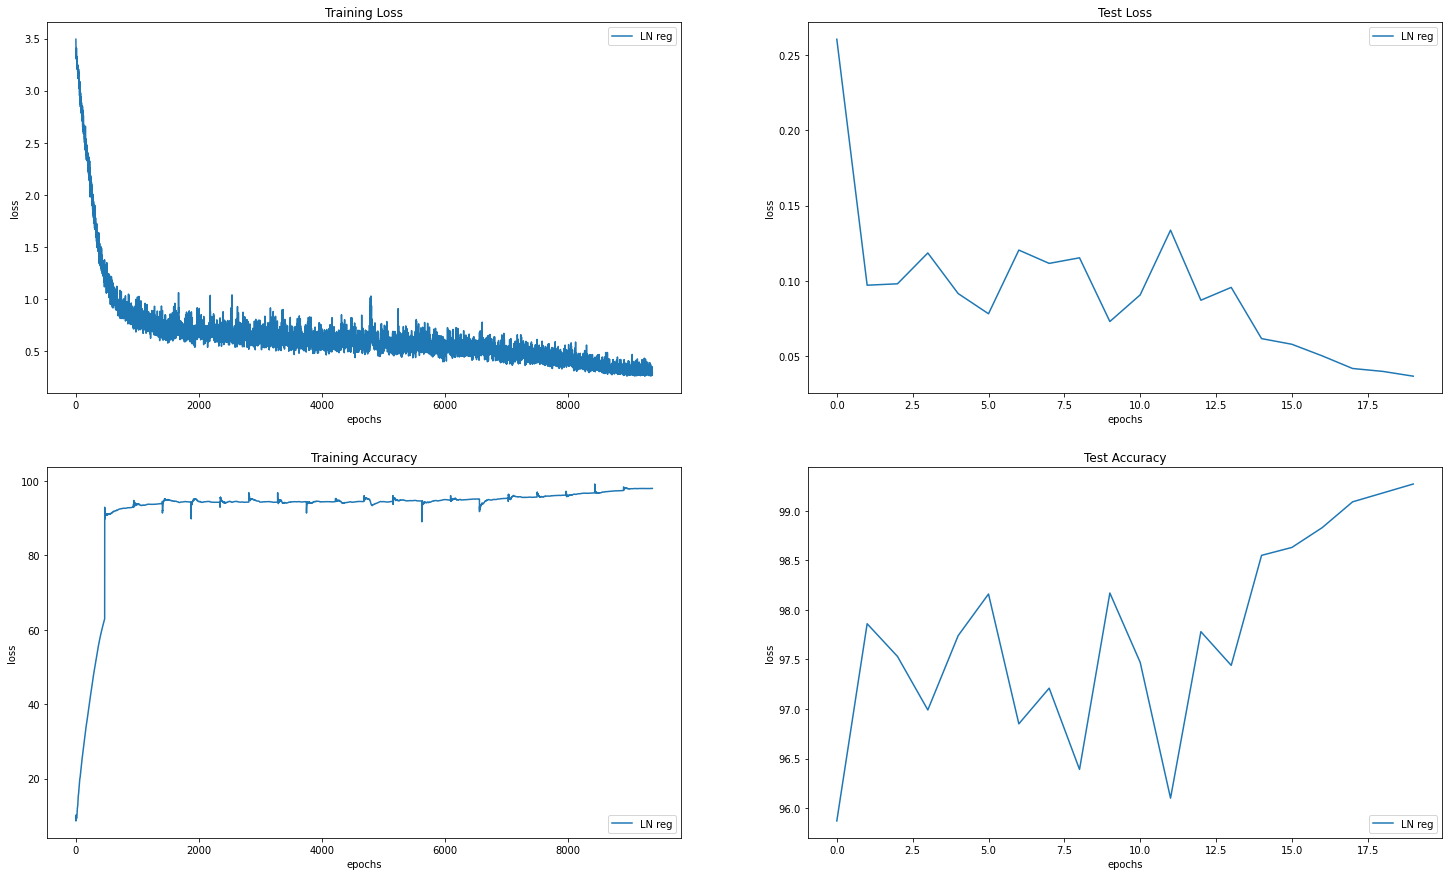

In [17]:
plot_metrics(exp_metrics)

In [19]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
   
    return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [21]:
wrong_predictions = wrong_predictions(test_loader,model,device)

In [22]:
print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 73


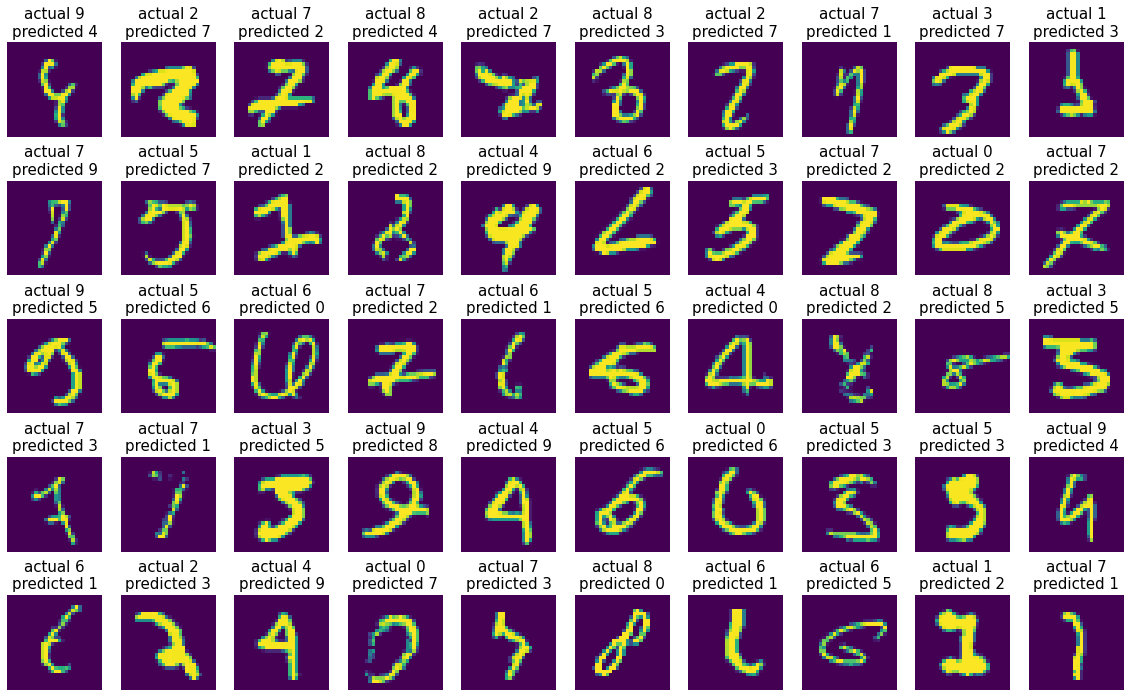

In [23]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(wrong_predictions[:50]):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()